In [12]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import torch_geometric as pyg

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.reinforce.Node2Vec import Node2Vec
from gsnn.reinforce.DGI import DGI
from gsnn.simulate.simulate import simulate
from gsnn.reinforce import utils

from gsnn.interpret.extract_entity_function import extract_entity_function

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = torch.load('../../gsnn-lib/processed_data/data.pt')

In [3]:
edge_index = data.edge_index_dict['function','to','function']
#rand_node = np.random.randint(0, len(data.node_names_dict['function']), size=1).item()
rand_node = 2442
row, col = edge_index 
neighborhood = torch.unique(edge_index[:, (row == rand_node) | (col == rand_node)]).detach().cpu().numpy()
colors = ['r' if i in neighborhood else 'k' for i in range(len(data.node_names_dict['function']))]
len(neighborhood)

112

In [50]:
#model = Node2Vec(edge_index, embedding_dim=124, walk_length=20, context_size=20, 
#                                    walks_per_node=25, num_negative_samples=1, p=1., q=1., sparse=True)
data = torch.load('../../gsnn-lib/processed_data/data.pt')
data2 = pyg.data.Data() 
data2.edge_index = data['edge_index_dict']['function','to','function']
data2.num_nodes = len(data['node_names_dict']['function'])

data2.x = torch.eye(data2.num_nodes) # one hot encode nodes 
#data2.x = torch.randn((data2.num_nodes, 10)) # one hot encode nodes 
#data2.x = torch.ones((data2.num_nodes, 1)) # one hot encode nodes 

model = DGI(data2, 124, dropout=0., layers=10, conv='gin')
model.train(lr=1e-4, epochs=100, device='cuda')
#model.plot(colors=colors)

In [51]:
score, labels = utils.dbscan_silhouette_score(torch.tensor(model.embed()), max_eps=10, min_samples=10)
print(score)
print(np.unique(labels))

0.009418219
[-1  0  1  2]


In [52]:
c = ['r','b','g', 'c', 'm', 'y', 'k', 'xkcd:sky blue', 'xkcd:grass green', 'xkcd:blood red']
colors = [c[i] for i in labels]

running umap embedding...


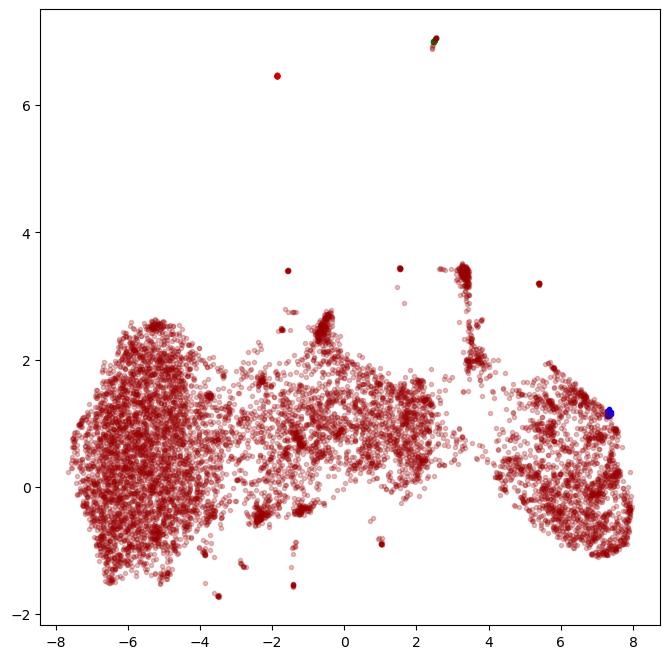

In [53]:
model.plot(colors=colors)

In [63]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import average_precision_score, roc_auc_score

In [64]:
x = model.embed()
#x = (x-x.mean(0))/ (x.std(0) + 1e-8)
y = (np.array(colors) == 'r')

idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

_n = 6000
x_train = x[:_n]
x_test = x[_n:]
y_train = y[:_n]
y_test = y[_n:]

lin = LogisticRegressionCV( max_iter=1000)
lin.fit(x_train,y_train)
p_test = lin.predict_proba(x_test)[:, 1]

print('auroc: ', roc_auc_score(y_test, p_test)) 
print('aupr: ', average_precision_score(y_test, p_test)) 

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [56]:
from sklearn.decomposition import PCA

In [57]:
z = model.embed()
#z = (z - z.mean(0))/(z.std(0) + 1e-8)
reducer = PCA(n_components=2)
u = reducer.fit_transform(z)

In [58]:
z.mean(0)

array([-0.94183254, -0.38225022,  0.9830833 , -0.9144748 , -0.70744973,
        0.86206174,  0.46905333, -0.52146214,  0.49374712,  0.1726216 ,
       -0.78928816, -0.02843768,  0.41388974,  0.9124167 ,  0.8109875 ,
       -0.9229486 , -0.3247814 ,  0.24596766,  0.52932775,  0.43541658,
       -0.8585646 , -0.75709367,  0.6886194 , -0.6450306 ,  0.5249851 ,
        0.33965304,  0.40288445, -0.4747029 ,  0.17760254,  0.08740386,
       -0.13133526, -0.69446856,  0.6146477 , -0.21106228,  0.5554483 ,
        0.42024055, -0.71368843,  0.73273706, -0.6931348 ,  0.39721128,
        0.8804016 ,  0.43084586, -0.4820991 ,  0.91380686, -0.5331388 ,
        0.89549017,  0.8812939 ,  0.19990614,  0.43715236, -0.48236084,
       -0.44870594,  0.5358365 ,  0.8373341 , -0.5709038 , -0.4256049 ,
       -0.7872448 , -0.6619394 ,  0.6293665 ,  0.8561954 , -0.32713678,
       -0.56610847,  0.32815212,  0.08313438,  0.5118201 , -0.54766417,
       -0.03857557,  0.7407755 , -0.72290283, -0.15588737, -0.62

In [59]:
u[np.array(data.node_names_dict['function']) == 'RNA__P04637']

array([[-9.309971 , -2.4804287]], dtype=float32)

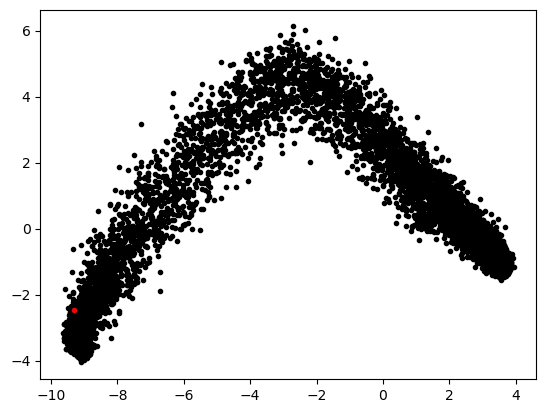

In [60]:
plt.figure()
plt.plot(*u.T, 'k.')

plt.plot(*u[np.array(data.node_names_dict['function']) == 'RNA__P04637'].ravel(), 'r.')
plt.show()

In [22]:
N2V = Node2Vec(edge_index, embedding_dim=256, walk_length=20, context_size=10, 
                                    walks_per_node=100, num_negative_samples=1, p=1., q=0.5, sparse=True)
N2V.train(epochs=50, lr=1e-2)
N2V.plot(colors=colors)

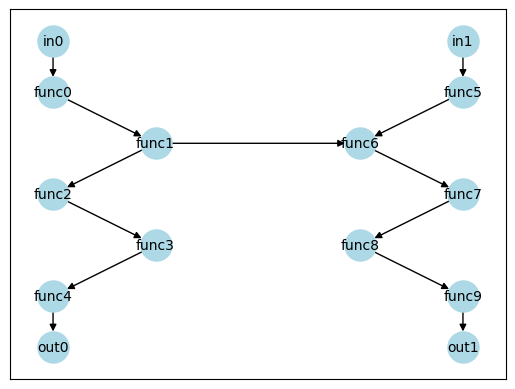

In [ ]:
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes for two disconnected subgraphs
input_nodes = ['in0', 'in1']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4'] + ['func5', 'func6', 'func7', 'func8', 'func9']
output_nodes = ['out0', 'out1']

# Add edges for first subgraph (input 1 -> function nodes -> output 1)
G.add_edges_from([('in0', 'func0'), ('func0', 'func1'), ('func1', 'func2'),
                  ('func2', 'func3'), ('func3', 'func4'), ('func4', 'out0'),
                  ('func1', 'func6')])

# Add edges for second subgraph (input 2 -> function nodes -> output 2)
G.add_edges_from([('in1', 'func5'), ('func5', 'func6'), ('func6', 'func7'),
                  ('func7', 'func8'), ('func8', 'func9'), ('func9', 'out1')])

# Plot the graph
pos = {
    'in0': (-1, 2), 'in1': (1, 2),
    'func0': (-1, 1.5), 'func1': (-0.5, 1), 'func2': (-1, 0.5), 'func3': (-0.5, 0), 'func4': (-1, -0.5),
    'func5': (1, 1.5), 'func6': (0.5, 1), 'func7': (1, 0.5), 'func8': (0.5, 0), 'func9': (1, -0.5),
    'out0': (-1, -1), 'out1': (1, -1)
}

nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

In [ ]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

In [ ]:
model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=10, 
             layers=5,
             residual=False,
             share_layers=True, 
             add_function_self_edges=False,
             
             norm='none')

In [ ]:
x = torch.tensor([[1, 0]], dtype=torch.float32)

In [ ]:
model(x)

tensor([[-0.0352,  0.0000]], grad_fn=<IndexBackward0>)